# RESOURCES
1. https://arxiv.org/pdf/2203.01831.pdf
2. https://arxiv.org/pdf/1801.01465.pdf

In [2]:
import qiskit
from qiskit import quantum_info
#from qiskit.execute_function import execute
from qiskit_aer import AerSimulator
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from PIL import Image
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA
from PIL import Image
import matplotlib.pyplot as plt
import sys
from qiskit.visualization import plot_histogram, plot_distribution




import matplotlib.image as img
# from qiskit import *
# from qiskit import IBMQ
# from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
# from qiskit.visualization import *

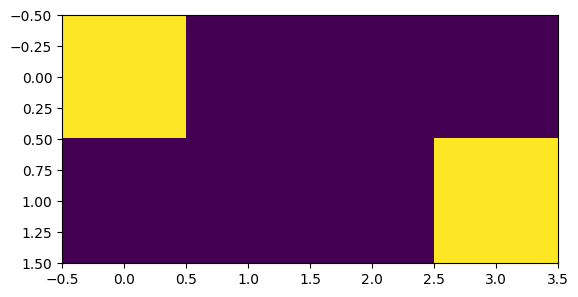

In [119]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 0, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1]])
            
#image = np.array((1,1,1,1)).reshape(2,2)
#image = np.array((3,2,2,3)).reshape(2,2)
# image = np.array((1,2,3,4)).reshape(2,2)
image = np.array((4,1,1,1,1,1,1,4)).reshape(2,4)
#image = np.array((1,2,3,4,1,2,3,4)).reshape(2,4)
image_path = '/workspaces/QC/murat.jpeg'  # Specify the path to your image file
#image = img.imread(image_path)[:,:,2].reshape(275,183)
#plt.imshow(image, cmap='gray', interpolation='nearest')
plt.imshow(image)
# np.where(image==0)[0].shape

from PIL import Image
#Open the image
# image = Image.open(image_path)
# image = image.resize((4, 8))
# image = np.array(image)[:,:,2]
# print(np.where(image==0))
# plt.imshow(image)

(32, 32, 3)


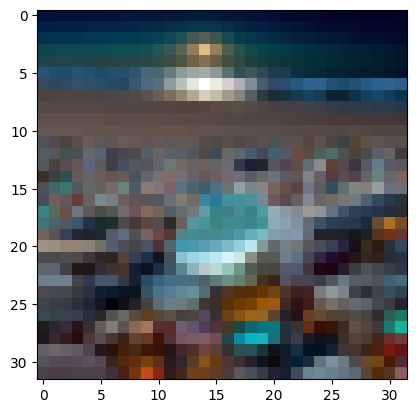

In [103]:
def classical_encode(image, M=349, N=351):
  """
  image:ndarray -> array of rgb data of shape (3, w, h)
  M:int -> first modular base
  N:int -> second modular base

  returns:
  modular_image:ndarray -> array of modular encoded rgb image of shape (w,h)
  """
  r,g,b = image[0], image[1], image[2]
  M,N = 349,351
  modular_image = (r*M*N)+(g*N)+b
  return modular_image

def classical_decode(modular_image, M=349, N=351):
  """
  modular_image:ndarray -> array of modular encoded rgb image 
  M:int -> first modular base
  N:int -> second modular base

  returns:
  reconstructed_image:ndarray -> reconstructed rgb image from modular_image 
  """
  r=modular_image%N
  g=(modular_image//N)%M
  b=(modular_image//(M*N))%M
  # reconstructed_image = np.stack((r,g,b),axis=0)
  reconstructed_image = np.stack((b,g,r),axis=0)
  return reconstructed_image

def get_qubits(image_width, image_height):
    num_qubits = np.ceil(np.log2(3* image_width * image_height))
    return int(num_qubits)

#mage_c = np.random.randint(1, 255, size=24).reshape(3,2,4)
#image = np.array((3,2,2,3,3,2,2,3)).reshape(2,4)
from PIL import Image
#Open the image
image_width = 32
image_height = 32
image_path = '/workspaces/QC/murat.jpeg'
image = Image.open(image_path)
image = image.resize((image_width, image_height))
image = np.array(image)
print(image.shape)
plt.imshow(image)

image = classical_encode(image)
#reconstructed_image = classical_decode(image)


In [104]:
def amplitude_encode(img_data):
    # Calculate the RMS value
    img_w, img_h = img_data.shape[0], img_data.shape[1]
    #print('--------',img_data.shape[0])
    pixel_num = img_w*img_h
    img_max = np.max(img_data)
    norm_img = img_data/img_max
    norm_sq = norm_img**2
    norm_sq_sum = np.sum(np.sum(norm_sq, axis=1))
    norm_sq_sum_root = np.sqrt(norm_sq_sum)

    temp = norm_img/norm_sq_sum_root
    print("Sum of pixel values to initialse qubits to sum to:", np.sum(temp**2))

    return temp.reshape(pixel_num), norm_sq_sum_root, pixel_num, img_max

test_img = np.array((1,1,1,9,1,9876549,1,1,678,1)).reshape(5,2)
amplitude_encoded, rms, pixel_num, img_max = amplitude_encode(image)

Sum of pixel values to initialse qubits to sum to: 1.0


In [105]:
# from qiskit import QuantumCircuit
#from qiskit.quantum_info import Statevector
# from qiskit import transpile

num_qubits = get_qubits(image_width=image_width, image_height=image_height)
print(num_qubits)
qc= QuantumCircuit(num_qubits)
qc.initialize(amplitude_encoded, range(0, num_qubits))
qc.measure_all()
result = AerSimulator(enable_truncation=True,shots=10000).run(qc).result()
statistics = result.get_counts(qc)
display(plot_histogram(statistics))
sorted_statistics = dict(sorted(statistics.items(), key=lambda x: x[0]))
print(sorted_statistics)




12


QiskitError: 'Desired statevector length not a positive power of 2.'

In [84]:
basis_states = sorted(list(dict(statistics).keys()))
sorted_statistics = dict(sorted(statistics.items(), key=lambda x: x[0]))
sorted_statistics

{'000': 1679511,
 '001': 1071809,
 '010': 2593943,
 '011': 31870,
 '100': 78531,
 '101': 1403900,
 '110': 2107,
 '111': 3138329}

In [85]:
amplitudes = np.array(list(dict(sorted_statistics).values()))
probabilities = amplitudes/np.sum(amplitudes)
decoded_result = np.sqrt(probabilities)
decoded_result = decoded_result*(rms)*img_max
decoded_result = decoded_result.reshape(image.shape)
#print(decoded_img)
decoded_result = np.round(decoded_result)
decoded_result = decoded_result.astype(int)
# print(decoded_result/max(decoded_result))
# print(image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


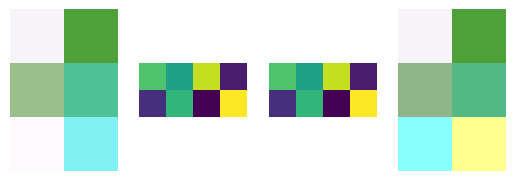

In [86]:
reconstructed_image = classical_decode(decoded_result)


fig, axs = plt.subplots(1, 4)
axs[0].imshow(image_c)
axs[0].axis('off')
axs[1].imshow(image/np.max(image))
axs[1].axis('off')
axs[2].imshow(decoded_result/np.max(decoded_result))
axs[2].axis('off')
axs[3].imshow(reconstructed_image)
axs[3].axis('off')
plt.subplots_adjust(wspace=0.2)
plt.show()

[[3 2 2 3]
 [3 2 2 3]]
[[3 2 2 3]
 [3 2 2 3]]


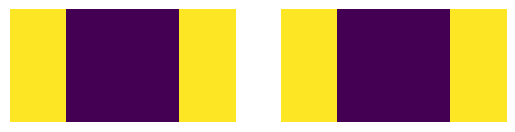

In [80]:
print(image)
print(decoded_result)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].axis('off')
axs[1].imshow(decoded_result)
axs[1].axis('off')
plt.show()

In [13]:
from itertools import product

# Generate all combinations of arranging 0s and 1s in groups of 5
combinations = list(product([0, 1], repeat=5))

# Print the combinations
for combination in combinations:
    print(combination)

(0, 0, 0, 0, 0)
(0, 0, 0, 0, 1)
(0, 0, 0, 1, 0)
(0, 0, 0, 1, 1)
(0, 0, 1, 0, 0)
(0, 0, 1, 0, 1)
(0, 0, 1, 1, 0)
(0, 0, 1, 1, 1)
(0, 1, 0, 0, 0)
(0, 1, 0, 0, 1)
(0, 1, 0, 1, 0)
(0, 1, 0, 1, 1)
(0, 1, 1, 0, 0)
(0, 1, 1, 0, 1)
(0, 1, 1, 1, 0)
(0, 1, 1, 1, 1)
(1, 0, 0, 0, 0)
(1, 0, 0, 0, 1)
(1, 0, 0, 1, 0)
(1, 0, 0, 1, 1)
(1, 0, 1, 0, 0)
(1, 0, 1, 0, 1)
(1, 0, 1, 1, 0)
(1, 0, 1, 1, 1)
(1, 1, 0, 0, 0)
(1, 1, 0, 0, 1)
(1, 1, 0, 1, 0)
(1, 1, 0, 1, 1)
(1, 1, 1, 0, 0)
(1, 1, 1, 0, 1)
(1, 1, 1, 1, 0)
(1, 1, 1, 1, 1)


Depth:  3
Probabilities dict from statevector:  {'000': 0.5, '111': 0.5}


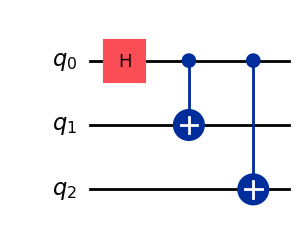

In [51]:
three_ghz = QuantumCircuit(3)
three_ghz.h(0)
three_ghz.cx(0,1)
three_ghz.cx(0,2) #alternativelya, you can use a cnot/cx gate here with qubit 1 (control) and qubit 2 (target)
depth = three_ghz.depth()
sv = Statevector.from_instruction(three_ghz).probabilities_dict(decimals=1)
print('Depth: ', depth)
print('Probabilities dict from statevector: ', sv)
three_ghz.draw('mpl')

In [7]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

# def understand_np_dot_roll():
#     arr = np.random.randint(1, 9, 16).reshape(4,4) * np.identity(4)
#     print("Random matrix generated\n", arr)
#     print("Shifting image by 1 in axis=1(x-axis)\n", np.roll(arr, 1, axis=1))
#     print("Shifting image by 1 in axis=1(x-axis) and by 1 in axis=0(y-axis) \n", np.roll(arr, (1,1), axis=(0,1)))
# understand_np_dot_roll()

In [30]:
#submission to part 1, you should make this into a .py file
n=len(images)
mse=0
gatecount=0
num_qubits = 8


def plot_image(img, title='Reconstructed image'):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
def encode(image):
    image_norm_h, rms, pixel_num = amplitude_encode(image)
    num_qubits = int(np.log2(pixel_num))
    print(f"{num_qubits} initialised for this image")
    qc_h = QuantumCircuit(num_qubits)
    qc_h.initialize(image_norm_h, range(0, num_qubits))
    return qc_h, rms, num_qubits

def simulate(circuit, show_histogram=True):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.get_statevector()
    probabilities = np.array(np.abs(statevector)**2)
    if show_histogram:
        plt.bar(range((2**circuit.num_qubits)), probabilities)
        plt.xlabel('Basis State')
        plt.ylabel('Probability')
        plt.show()
    return probabilities

def decode(probabilities, rms):
    prob_sqrt = np.sqrt(probabilities)
    reconstructed_image = prob_sqrt * rms
    dim = int(np.sqrt(len(reconstructed_image)))
    return reconstructed_image.reshape(dim, dim)

def run_part1(image):
    #encode image into a circuit
    circuit, rms, num_qubits = encode(image)

    #simulate circuit
    histogram=simulate(circuit, show_histogram=False)

    #reconstruct the image
    image_re=decode(histogram, rms)

    return circuit,image_re, num_qubits 

def resize_iamges(dataset, resized_dimention=16):
    temp_dataset = np.empty((dataset.shape[0], resized_dimention, resized_dimention))
    for index,img in dataset:
        img = Image.fromarray(img)
        img = np.array(img.resize((resized_dimention, resized_dimention)))
        temp_dataset[index] = img
    return temp_dataset




qubits_list = list(range(num_qubits))
feature_map = ZFeatureMap(num_qubits)  # initialise feature map to capture total pixels

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), qubits=list(range(8)), inplace=True)
# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)
   

#print(ansatz.parameters)
circuit.compose(feature_map, range(8), inplace=True)
#circuit.append(feature_map, range(num_qubits))
circuit.compose(ansatz, range(8), inplace=True)
#circuit.append(ansatz, range(num_qubits))

#circuit.decompose().draw("mpl", fold=-1)

# circuit2, test_image2 = run_part1(img.T)
#plot_image(test_image)

NameError: name 'images' is not defined

In [ ]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=10),  # Set max iterations here
    callback=callback_graph
)

In [ ]:
train_images = resize_images(train_images, resized_dimention=16)
test_images = resize_images(test_images, resized_dimention=16)

classifier.fit(train_images, train_labels)

plt.rcParams["figure.figsize"] = (12, 6)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [ ]:
#how we grade your submission

n=len(images)
mse=0
gatecount=0

for data in images:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

In [ ]:
def conv_circuit(params):
    """
    params is a parameter vector
    """
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# # Let's draw this circuit and see what it looks like
# params = ParameterVector("θ", length=3)
# circuit = conv_circuit(params)
# circuit.draw("mpl")

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
        #print('qi',q1,'q2',q2)
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# circuit = conv_layer(4, "θ")
# circuit.decompose().draw("mpl", fold=100)


def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# params = ParameterVector("θ", length=3)
# circuit = pool_circuit(params)
# circuit.draw("mpl")


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# sources = [0, 1] # qubits from which information will be 'transferred'
# sinks = [2, 3] #qubits to which transferred information will be encoded
# circuit = pool_layer(sources, sinks, "θ")
# circuit.decompose().draw("mpl")